In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt
import lightgbm 

In c:\dev\projects\ai-notebooks\.venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\dev\projects\ai-notebooks\.venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\dev\projects\ai-notebooks\.venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\dev\projects\ai-notebooks\.venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\dev\projects\ai-notebooks\.venv\lib\site-packa

In [2]:
target="granted_number_of_night"

In [3]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


In [4]:
X_train = pd.read_csv(filepath_or_buffer='data/cleaned_data/X_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

X_test = pd.read_csv(filepath_or_buffer='data/cleaned_data/X_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

y_train = pd.read_csv(filepath_or_buffer='data/cleaned_data/y_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

y_test = pd.read_csv(filepath_or_buffer='data/cleaned_data/y_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)





In [5]:
print(f"Shape of X_train is :{X_train.shape}")
print(f"Shape of y_train is :{y_train.shape}")
print(f"Shape of X_test is :{X_test.shape}")
print(f"Shape of y_test is :{y_test.shape}")

Shape of X_train is :(384075, 109)
Shape of y_train is :(384075, 1)
Shape of X_test is :(95641, 109)
Shape of y_test is :(95641, 1)


## Data balancing
Over sampling technique, [SMOTE]()

[INFO] : if you set class_weight params in LGBM or RF don't do this step of data balancing

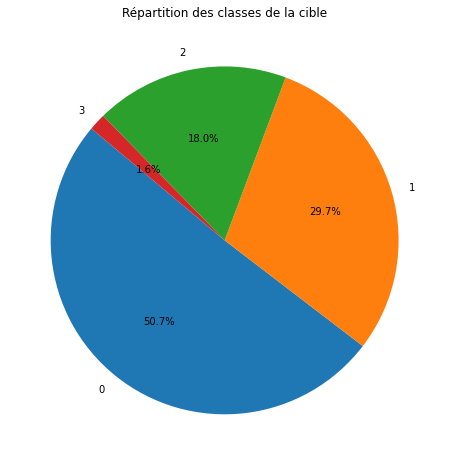

In [22]:
labels = ['0','1','2','3']
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels = labels, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des classes de la cible')
plt.show()

In [55]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = smote.fit_resample(X_test, y_test)

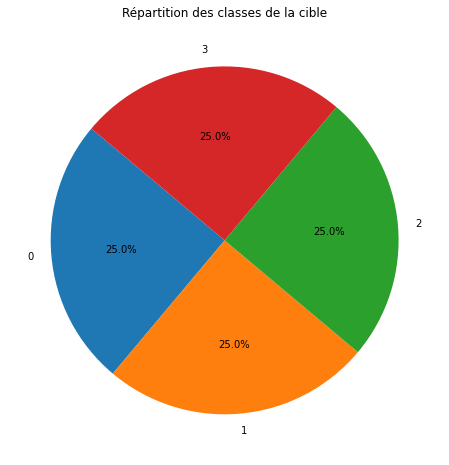

In [56]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels = labels, autopct='%1.1f%%', startangle=140 )
plt.title('Répartition des classes de la cible')
plt.show()

In [26]:
print(f"Shape of X_train is :{X_train.shape}")
print(f"Shape of y_train is :{y_train.shape}")

Shape of X_train is :(779140, 109)
Shape of y_train is :(779140, 1)


## RandomForestClassifier
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Hyperparams opt

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    #'learning_rate': [0.01, 0.05, 0.1],
    #'n_estimators': [500, 1000, 2000],
    #'max_depth': [5, 7, 10],
    #'min_child_samples': [10, 20, 30],
}

RF =RandomForestClassifier()
grid = GridSearchCV(RF,
                     param_grid= {
                         'num_leaves':np.arange(50, 100, 200)
                         },
                     scoring='neg_log_loss',
                     cv=5,
                     verbose=1,
                     return_train_score=True)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

In [13]:
class_weights = {0: 0, 1: 10, 2: 100, 3: 1000}
clf= RandomForestClassifier (n_estimators =100, max_depth=20, class_weight=class_weights)
clf.fit(X_train, y_train)

c:\dev\projects\ai-notebooks\.venv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(class_weight={0: 0, 1: 10, 2: 100, 3: 1000},
                       max_depth=20)

### Evaluation

In [14]:
y_preds = clf.predict_proba(X_test)
y_true = y_test.granted_number_of_nights.values
random_score = competition_scorer(y_true, y_preds)

print(f'test score: {random_score}')

test score: 1.54404180863218


In [15]:
y_pred = clf.predict(X_test)

In [16]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy score is :{accuracy}")

Accuracy score is :0.18734643092397613


## LGBM

In [9]:
X_train.columns = X_train.columns.str.replace(r'[^\w]','_', regex=True)
print(X_train.columns.tolist())

['animal_presence', 'child_situation', 'child_to_come', 'district', 'group_composition_id', 'group_type', 'housing_situation_id', 'long_term_housing_request', 'number_of_underage', 'victim_of_violence', 'housing_situation_2_id', 'birth_month', 'birth_year', 'disabled_worker_certification', 'gender', 'individual_role_2_id', 'marital_status_id', 'pregnancy', 'group_composition_label_INCONNU', 'group_composition_label_accompanied_child_underage', 'group_composition_label_child_underage_with_family', 'group_composition_label_couple_with_child_ren_', 'group_composition_label_couple_without_whildren', 'group_composition_label_group_of_adults', 'group_composition_label_group_with_child_ren_', 'group_composition_label_isolated_child_underage', 'group_composition_label_man_alone', 'group_composition_label_single_father_with_child_ren_', 'group_composition_label_single_mother_with_child_ren_', 'group_composition_label_woman_alone', 'group_composition_label_women_victim_of_violence', 'housing_sit

### Hyperparams opt

In [27]:
num_leaves = 50
max_depth= 5
learning_rate = 0.01
n_estimator = 500
min_child_samples = 10
class_weights = {0: 0, 1: 10, 2: 100, 3: 1000}

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    #'learning_rate': [0.01, 0.05, 0.1],
    #'n_estimators': [500, 1000, 2000],
    #'max_depth': [5, 7, 10],
    #'min_child_samples': [10, 20, 30],
}

lgbm = lightgbm.LGBMClassifier(num_leaves=num_leaves,
                               min_child_samples = min_child_samples,
                                max_depth=max_depth,
                                n_estimators=n_estimator,
                                learning_rate=learning_rate,
                                class_weight=class_weights)
grid = GridSearchCV(lgbm,
                     param_grid= {
                         'num_leaves':np.arange(50, 100, 200)
                         },
                     scoring='neg_log_loss',
                     cv=5,
                     verbose=1,
                     return_train_score=True)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\dev\projects\ai-notebooks\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\dev\projects\ai-notebooks\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\dev\projects\ai-notebooks\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\dev\projects\ai-notebooks\.venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Best parameters: {'num_leaves': 50}


Best params are : {
   'learning_rate': 0.01,
   'n_estimator': 500,
}

In [28]:
lgbm = lightgbm.LGBMClassifier(num_leaves=num_leaves,
                               min_child_samples=min_child_samples,
                                max_depth=max_depth,
                                n_estimators=n_estimator,
                                learning_rate=learning_rate,
                                class_weight=class_weights)
lgbm.fit(X_train, y_train.values.ravel())

LGBMClassifier(class_weight={0: 0, 1: 10, 2: 100, 3: 1000}, learning_rate=0.01,
               max_depth=5, min_child_samples=10, n_estimators=500,
               num_leaves=50)

### Evaluation

In [29]:
#random_preds = np.random.uniform(size=(X_test.shape[0], 4))
random_preds = lgbm.predict_proba(X_test)
y_true = y_test.granted_number_of_nights.values
random_score = competition_scorer(y_true, random_preds)

print(f'test score: {random_score}')

test score: 1.6600428247985606
